In [23]:
from statsmodels.graphics.tsaplots import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg 
from pmdarima import auto_arima
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Step #1: Read Data

In [24]:
# Read data
df = pd.read_csv('../.dataset/BTC-USD-3.2018-3.2024.csv', parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904
...,...,...,...,...,...,...,...
2188,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,54522.402344,34074411896
2189,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,57085.371094,49756832031
2190,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,62504.789063,83239156760
2191,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,61198.382813,65496611844


# Step #2: Explore the Data

In [25]:
# Dataset Description
df = df.set_index('Date')
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Info: {df.info()}")
print(f"Dataset Describe: {df.describe()}")


Dataset Shape: (2193, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2193 entries, 2018-03-01 to 2024-03-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2193 non-null   float64
 1   High       2193 non-null   float64
 2   Low        2193 non-null   float64
 3   Close      2193 non-null   float64
 4   Adj Close  2193 non-null   float64
 5   Volume     2193 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 119.9 KB
Dataset Info: None
Dataset Describe:                Open          High           Low         Close     Adj Close  \
count   2193.000000   2193.000000   2193.000000   2193.000000   2193.000000   
mean   22705.310922  23217.108536  22164.070169  22727.117088  22727.117088   
std    16415.707425  16828.247923  15967.197094  16431.977633  16431.977633   
min     3236.274658   3275.377930   3191.303467   3236.761719   3236.761719   
25%     8370.049805   8585.150391   8185.763184

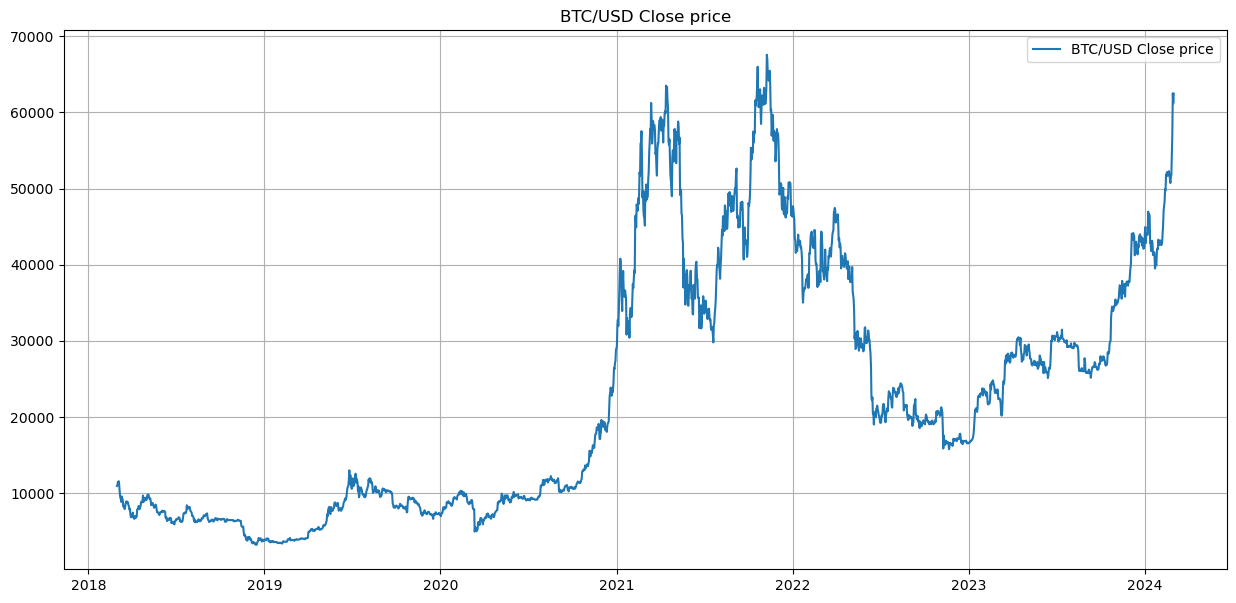

In [26]:
# Plotting data
plt.figure(figsize=(15, 7))
plt.plot(df.Close, label='BTC/USD Close price')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()



# Step #3: Feature Engineering

In [27]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

                  Close       MACD        RSI  Bollinger_Upper  Bollinger_Lower         MA26        EMA20    K-ratio
Date                                                                                                                
2018-10-02  6556.100098 -10.684094  63.027742      6792.186134      6313.780956  6502.164645  6584.695354  57.365334
2018-10-03  6502.589844 -16.371112  49.387182      6792.002241      6312.492828  6503.530799  6576.875781  27.901531
2018-10-04  6576.689941 -14.729068  43.431147      6794.686803      6316.206264  6517.019644  6576.858082  45.026575
2018-10-05  6622.479980  -9.621947  42.845692      6800.417097      6318.403948  6529.389648  6581.203025  55.608969
2018-10-06  6588.310059  -8.236796  50.614096      6803.448380      6322.485653  6539.336182  6581.879885  51.206746
                  Close  MACD_lag1   RSI_lag1  Bollinger_Upper_lag1  Bollinger_Lower_lag1    MA26_lag1   EMA20_lag1  K-ratio_lag1
Date                                               

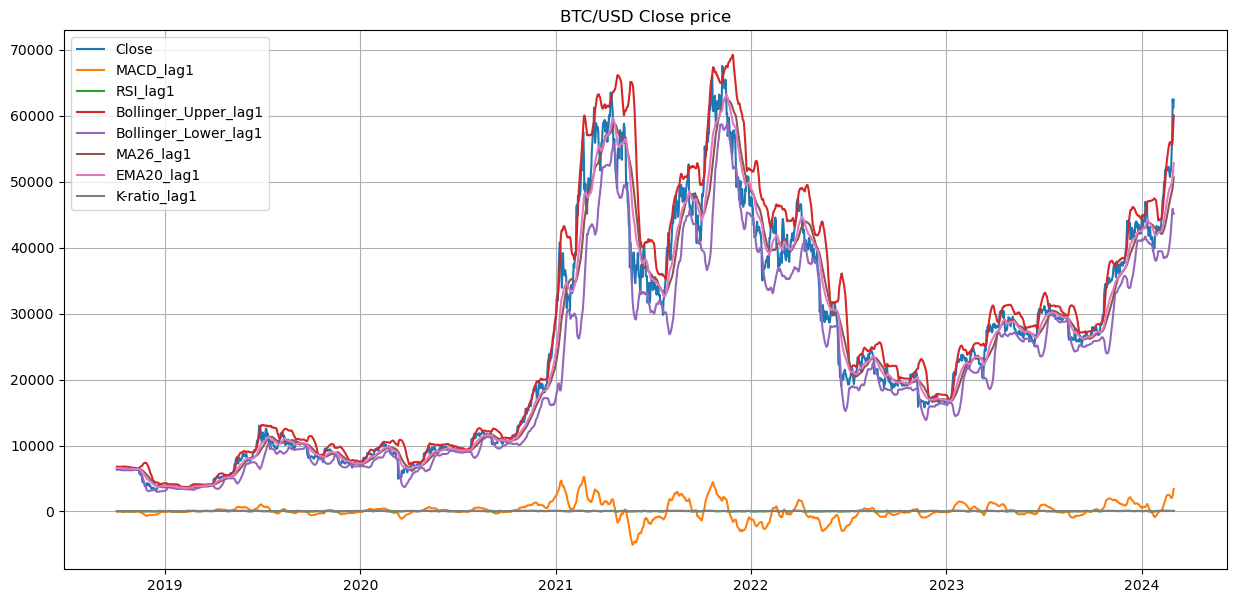

In [28]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())

# Create the lag of FEATURES (1 day before)
for feature in FEATURES:
   # drop the original feature except for the close price
    if feature != 'Close':
        df_filtered[feature + '_lag1'] = df_filtered[feature].shift(1)
        df_filtered.drop(feature, axis=1, inplace=True)
        
  
    

# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
print(df_filtered.head().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


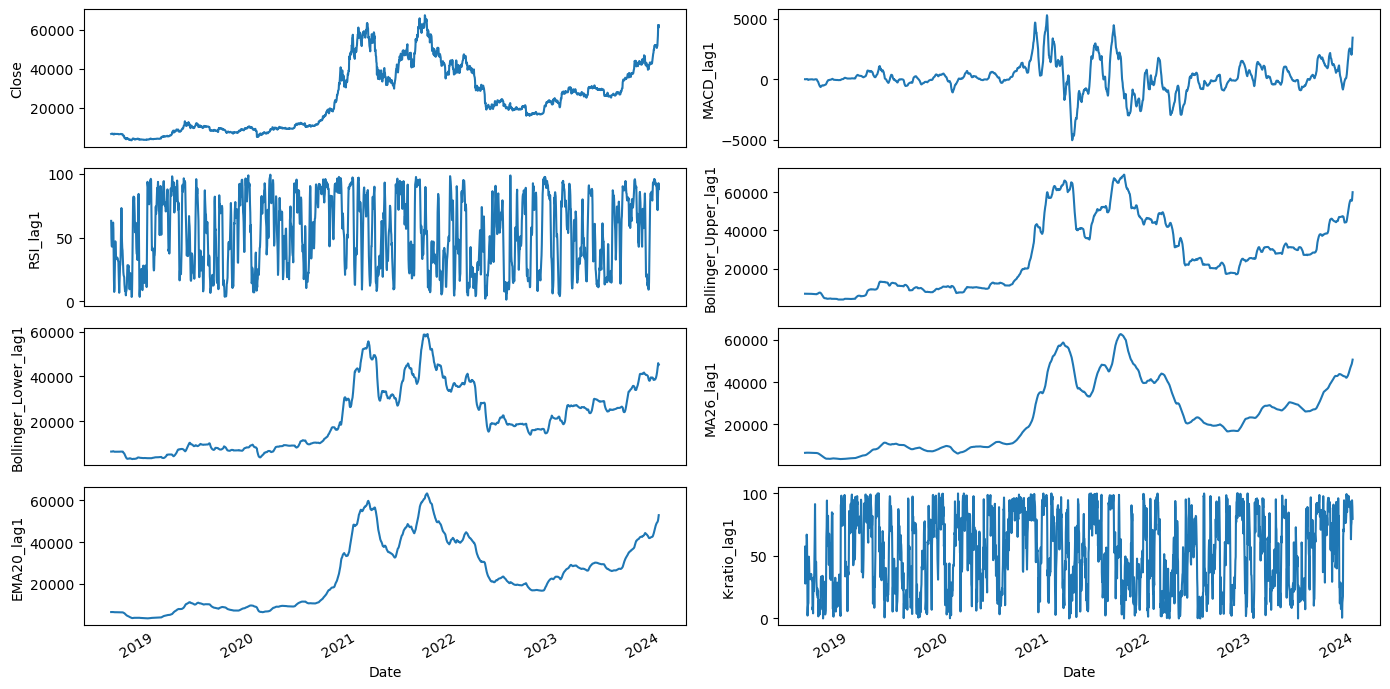

In [29]:
# Plot line charts
df_plot = df_filtered.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

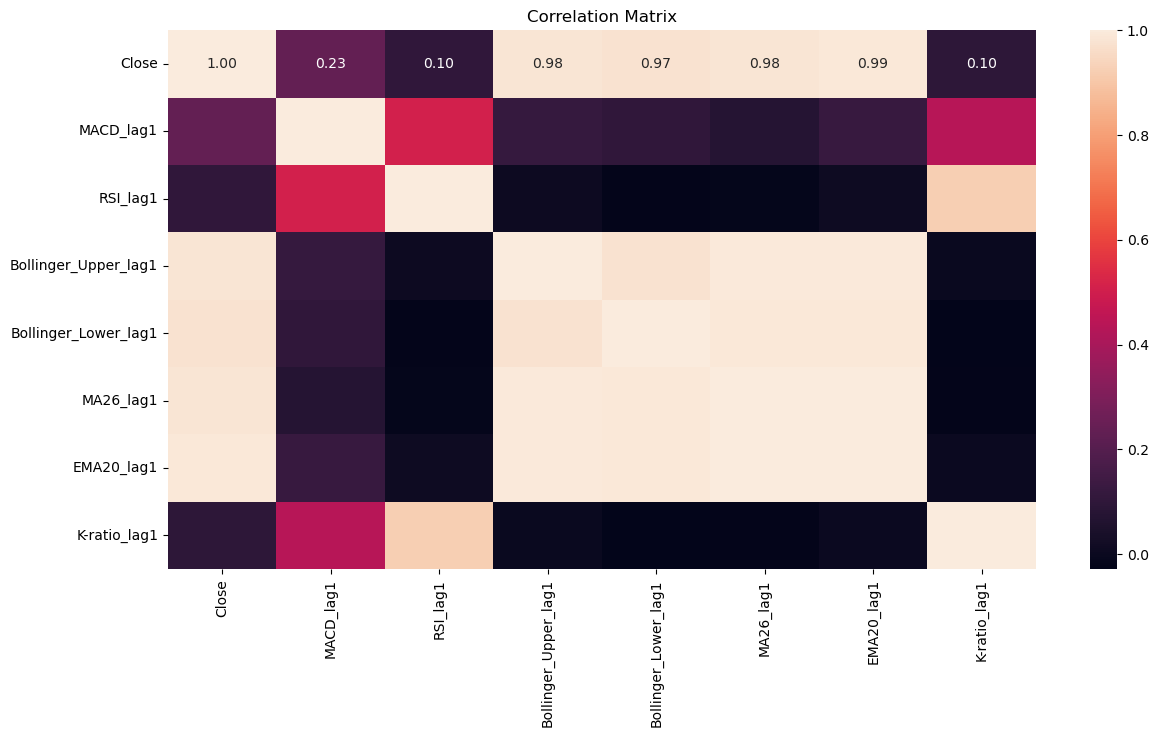

In [30]:
# Coorelation Matrix
plt.figure(figsize=(14, 7))
sns.heatmap(df_filtered.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



# Step #4: Train & Test split

In [31]:
# Train-Validation-Test Split
def split_data(df, test_size=0.15, valid_size=0.1):
    ntest = int(len(df)*test_size)
    nvalid = int(len(df)*valid_size)
    ntrain = len(df) - ntest - nvalid
    train = df.iloc[:ntrain].copy()
    valid = df.iloc[ntrain:ntrain+nvalid].copy()
    test = df.iloc[ntrain+nvalid:].copy()
    return train, valid, test

# Split the data
train, valid, test = split_data(df_filtered, test_size=0.15, valid_size=0.1)


# Step #5: Model Specification

**ARIMAX**

**1. Check for stationary**

In [32]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag='AIC', regression='ct')
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    # print("1. ADF : ",dftest[0])
    # Print dataset cols
    # print("3. Num Of Lags : ", dftest[2])
    # print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    # # print("5. Critical Values :")
    # for key, val in dftest[4].items():
    #    print("\t",key, ": ", val)
    if (dftest[0] < dftest[4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]):
        print ("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print ("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False
      

In [33]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*"*50 + f" Differencing of order {diff_order} " + "*"*50)
    train_diff = pd.DataFrame(np.diff(train, diff_order, axis=0), columns=train.columns)
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'Close' -> p-value: 0.899
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MACD_lag1' -> p-value: 0.002
Reject Ho - Time Series is Stationary
ADF Test on 'RSI_lag1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'Bollinger_Upper_lag1' -> p-value: 0.961
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'Bollinger_Lower_lag1' -> p-value: 0.803
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'MA26_lag1' -> p-value: 0.872
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'EMA20_lag1' -> p-value: 0.599
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'K-ratio_lag1' -> p-value: 0.000
Reject Ho - Time Series is Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'Clos

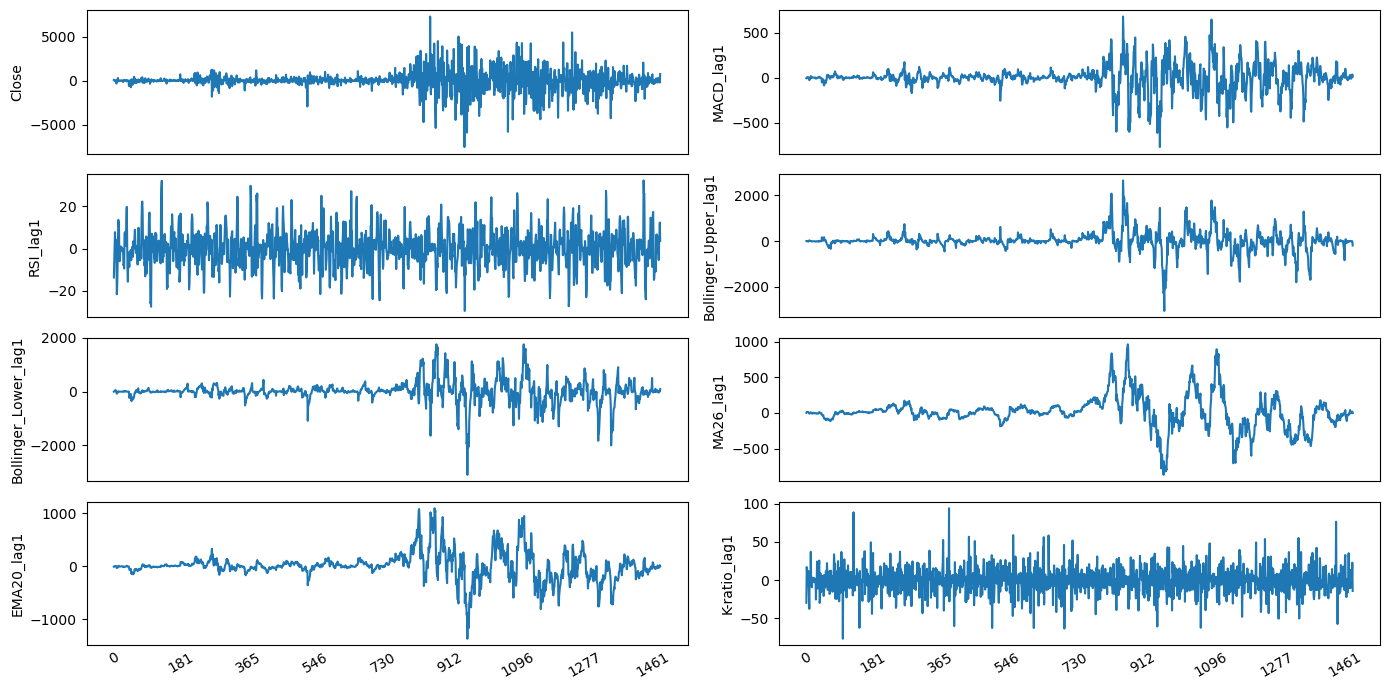

In [34]:
# Plot line charts
df_plot = train_diff.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'PACF')

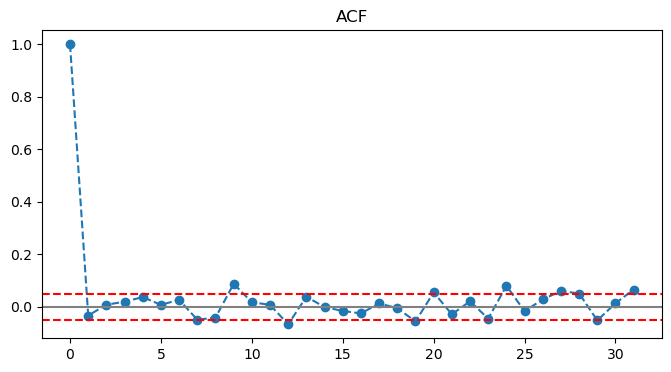

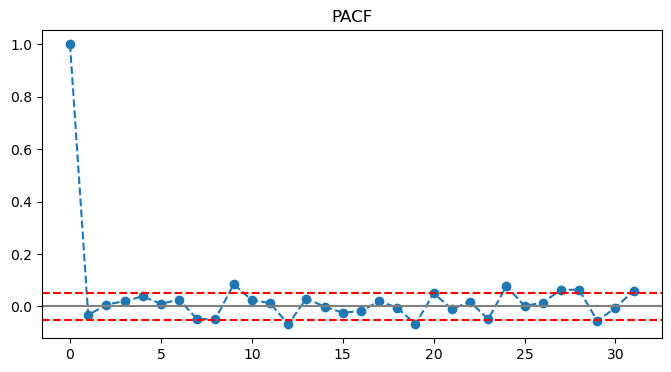

In [35]:
# Plot ACF and PACF
acf_plot = acf(train_diff['Close'])
pacf_plot = pacf(train_diff['Close'])
# Plot ACF
plt.figure(figsize=(8, 4))
plt.plot(acf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.title('ACF')

# Plot PACF
plt.figure(figsize=(8, 4))
plt.plot(pacf_plot, marker='o', linestyle='--')
plt.axhline(y=0, color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(train_diff)), color='red', linestyle='--')
plt.title('PACF')

**2. Choose the “p” level of AR model and “q” level for MA model**

In [36]:
# Find the best ARIMA model
def _arima_fit(orders, data, exog=None):
    models = dict()
    # Print arima fit with AIC and BIC decending
    for order in tqdm_notebook(orders):
        model = ARIMA(data, order=order, exog=exog)
        model_fit = model.fit()
        models[order] = model_fit
    return models

In [37]:
# Estimate ARIMA models with different p, q values through PCAF and ACF plots
list_q = [0, 1, 4, 7] # q values picked from PACF plot
list_p = [0, 1, 4, 7] # p values picked from ACF plot
order_list = list(product(list_p, [diff_order], list_q))

models = _arima_fit(order_list, train['Close'], train.drop(columns=['Close']))

  0%|          | 0/16 [00:00<?, ?it/s]

**3. Validation and tuning model**

In [38]:
# Validate the model with the validation set with AIC and BIC, then pick the best model based on RMSE
def _validate_models(models, valid, exog=None):
    # Get 10 top models based on AIC
    top_models = sorted(models.items(), key=lambda x: x[1].aic)[:10]
    print("Top 10 models based on AIC")
    for order, model in top_models:
        print(f"Order: {order} -> AIC: {model.aic:.2f}")
    # Validate the models
    best_model = None
    best_RMSE = float('inf')
    best_order = None
    for order, model in top_models:
        forecast = model.forecast(steps=len(valid), exog=exog)
        mse = np.mean((forecast - valid['Close'])**2)
        rmse = np.sqrt(mse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_model = model
            best_order = order
    return best_model, best_order, best_RMSE
        
        

# Validate the models
best_model, best_order, best_RMSE = _validate_models(models, valid, valid.drop(columns=['Close']))

print(f"\nBest Order: {best_order} -> Best RMSE: {best_RMSE:.2f}")
print(best_model.summary())

Top 10 models based on AIC
Order: (7, 1, 4) -> AIC: 24967.87
Order: (7, 1, 7) -> AIC: 24969.81
Order: (4, 1, 4) -> AIC: 24971.12
Order: (4, 1, 7) -> AIC: 24971.37
Order: (0, 1, 1) -> AIC: 24975.47
Order: (1, 1, 0) -> AIC: 24975.50
Order: (0, 1, 0) -> AIC: 24976.46
Order: (1, 1, 1) -> AIC: 24977.51
Order: (0, 1, 7) -> AIC: 24979.70
Order: (0, 1, 4) -> AIC: 24979.78

Best Order: (0, 1, 1) -> Best RMSE: 3972.03
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1484
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -12478.736
Date:                Sat, 04 May 2024   AIC                          24975.472
Time:                        00:23:33   BIC                          25023.189
Sample:                    10-03-2018   HQIC                         24993.259
                         - 10-25-2022                                         
Covariance Type:                  o

**4. Forecasting**

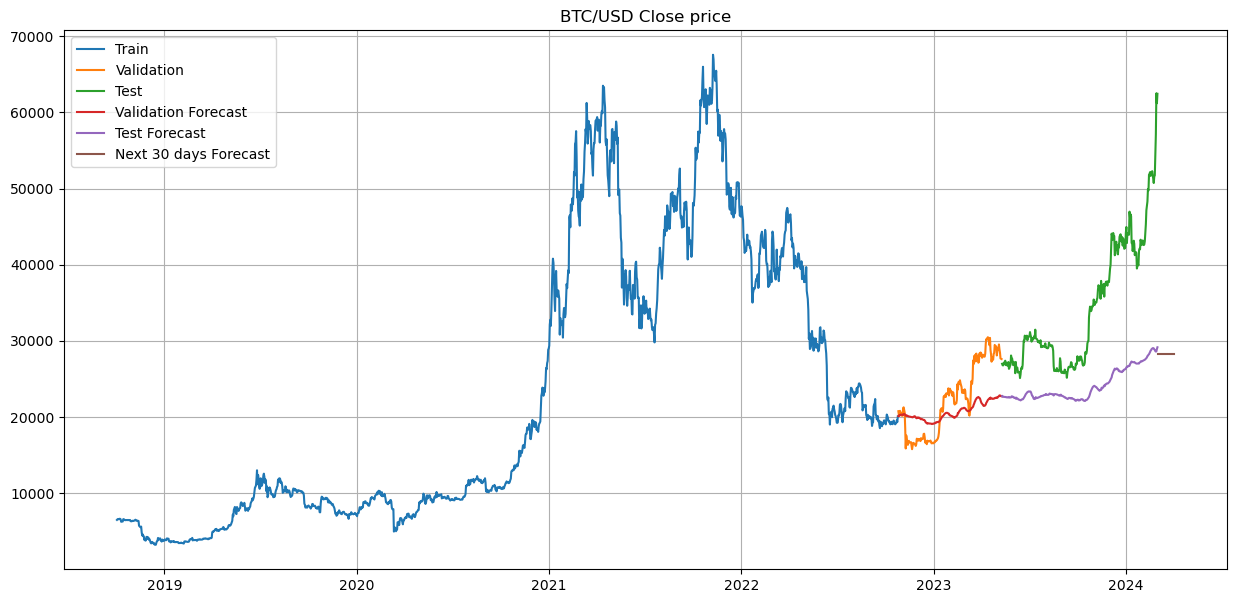

In [39]:
# Forecast on validation set and test set
forecast_valid = best_model.forecast(steps=len(valid), exog=valid.drop(columns=['Close']))
forecast_valid.index = valid.index
# test forecast
forecast_test_valid = best_model.forecast(steps=len(test)+len(valid), exog=np.concatenate([valid.drop(columns=['Close']), test.drop(columns=['Close'])]))
forecast_test = forecast_test_valid[len(valid):]
forecast_test.index = test.index


# Create the forecast's exogenous variables
num_days_forecast = dt.date(2024, 4, 1) - test.index.max().date()

future_exog = test.iloc[-num_days_forecast.days:].mean()
df_exog_future = pd.DataFrame([future_exog] * num_days_forecast.days, columns=train.drop(columns=['Close']).columns)
df_exog_future.index = pd.date_range(start=test.index.max() + dt.timedelta(days=1), periods=num_days_forecast.days)

# Forecast
forecast_next_30_days = best_model.forecast(steps=num_days_forecast.days, exog=df_exog_future)
forecast_next_30_days.index = df_exog_future.index

# Plot the overall
plt.figure(figsize=(15, 7))
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Validation')
plt.plot(test['Close'], label='Test')
plt.plot(forecast_valid, label='Validation Forecast')
plt.plot(forecast_test, label='Test Forecast')
plt.plot(forecast_next_30_days, label='Next 30 days Forecast')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()


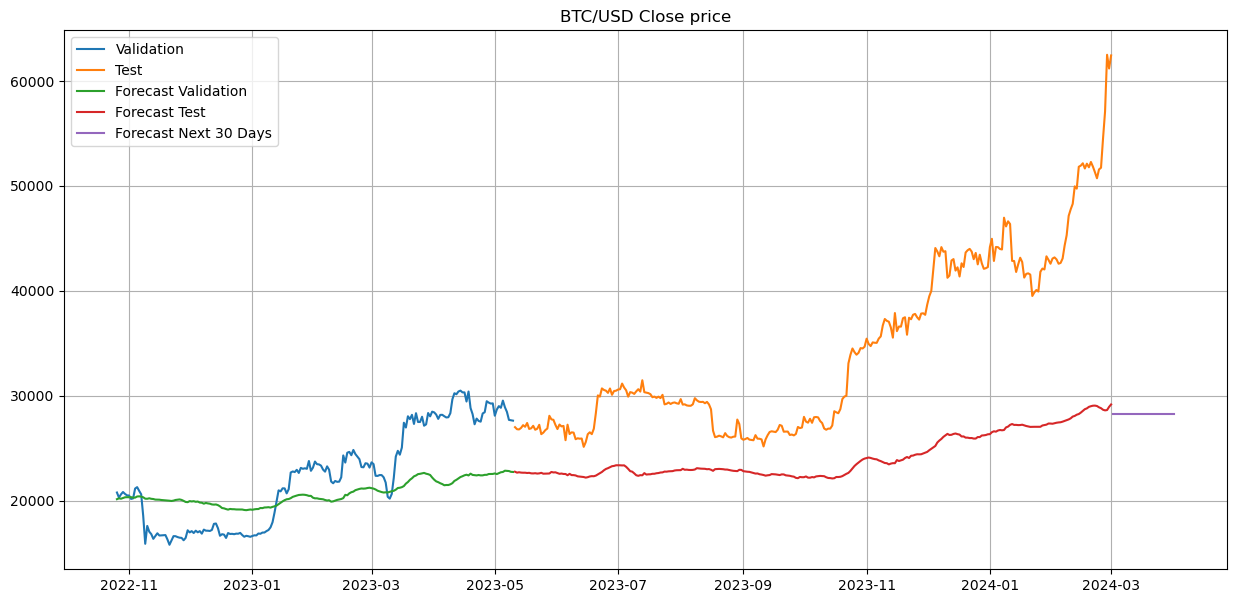

In [40]:
# Plot the forecast
plt.figure(figsize=(15, 7))
plt.plot(valid['Close'], label='Validation')
plt.plot(test['Close'], label='Test')
plt.plot(valid.index, forecast_valid, label='Forecast Validation')
plt.plot(test.index, forecast_test, label='Forecast Test')
plt.plot(forecast_next_30_days, label='Forecast Next 30 Days')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()

# Step #6: Model Evaluation

In [41]:
# Calculate the Model's RMSE, MAPE, and SMAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape

# Calculate the metrics
rmse, mape, smape = calculate_metrics(test['Close'], forecast_test)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")


RMSE: 12002.59
MAPE: 27.12
SMAPE: 32.27


In [ ]:
# Invert differencing for the forecast
def invert_diff(train, forecast, diff_order):
    forecast = forecast.cumsum()
    forecast = forecast + train.shift(diff_order).iloc[0]
    return forecast